In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
from pysal.explore.esda.moran import Moran, Moran_Local
from pysal.lib import weights
from libpysal.weights import Queen, Rook, DistanceBand
from sklearn.preprocessing import MinMaxScaler
import contextily as ctx
import warnings
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib.colors import Normalize,ListedColormap
import networkx as nx
from geopy.distance import geodesic
from scipy.spatial.distance import cdist
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from folium import Map, Circle, LayerControl
from folium.plugins import HeatMap

In [32]:
warnings.filterwarnings('ignore')

In [33]:
data=pd.read_csv('Preprocessed_Dataset.csv')

In [34]:
# Convert the 'Measurement date' column to datetime format
data['Measurement date'] = pd.to_datetime(data['Measurement date'])

# Handle missing data
# Fill missing pollutant values with linear interpolation
pollutant_columns = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

In [35]:
data.head()

Measurement date  Station code  \
0 2017-01-01 00:00:00           101   
1 2017-01-01 01:00:00           101   
2 2017-01-01 02:00:00           101   
3 2017-01-01 03:00:00           101   
4 2017-01-01 04:00:00           101   

                                             Address   Latitude   Longitude  \
0  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
1  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
2  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
3  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   
4  19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...  37.572016  127.005008   

     SO2    NO2     O3        CO  PM10  PM2.5  
0  0.004  0.059  0.002  0.499011  73.0   57.0  
1  0.004  0.058  0.002  0.499011  71.0   59.0  
2  0.004  0.056  0.002  0.499011  70.0   59.0  
3  0.004  0.056  0.002  0.499011  70.0   58.0  
4  0.003  0.051  0.002  0.499011  69.0   61.0

In [42]:
# Normalize pollutant levels
scaler = MinMaxScaler()
data[pollutant_columns] = scaler.fit_transform(data[pollutant_columns])

In [43]:
# Add date-related columns
data['Date'] = data['Measurement date'].dt.date
data['Month'] = data['Measurement date'].dt.to_period('M')  # Monthly period
data['Season'] = data['Measurement date'].dt.month % 12 // 3 + 1  # Seasons: 1=Winter, 2=Spring, 3=Summer, 4=Autumn

In [44]:
# Map season numbers to names for readability
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
data['Season'] = data['Season'].map(season_map)

In [45]:
# Daily Aggregation
daily_data = data.groupby(['Date', 'Station code', 'Latitude', 'Longitude'])[pollutant_columns].mean().reset_index()

# Monthly Aggregation
monthly_data = data.groupby(['Month', 'Station code', 'Latitude', 'Longitude'])[pollutant_columns].mean().reset_index()

# Seasonal Aggregation
seasonal_data = data.groupby(['Season', 'Station code', 'Latitude', 'Longitude'])[pollutant_columns].mean().reset_index()

In [143]:
monthly_data.head()

Month  Station code   Latitude   Longitude       SO2       NO2        O3  \
0  2017-01           101  37.572016  127.005008  0.510753  0.521108  0.202321   
1  2017-01           102  37.564263  126.974676  0.526798  0.536584  0.193312   
2  2017-01           103  37.540033  127.004850  0.567456  0.448281  0.165650   
3  2017-01           104  37.609823  126.934848  0.536122  0.365383  0.193076   
4  2017-01           105  37.593742  126.949679  0.707913  0.395313  0.243443   

         CO      PM10     PM2.5  
0  0.584917  0.477239  0.496364  
1  0.532007  0.486824  0.508825  
2  0.551099  0.434153  0.481535  
3  0.663535  0.484333  0.450787  
4  0.608887  0.514751  0.446677

In [144]:
# Spatial Aggregation (optional) - for each level
spatial_daily = daily_data.groupby(['Latitude', 'Longitude'])[pollutant_columns].mean().reset_index()
spatial_monthly = monthly_data.groupby(['Latitude', 'Longitude'])[pollutant_columns].mean().reset_index()
spatial_seasonal = seasonal_data.groupby(['Latitude', 'Longitude'])[pollutant_columns].mean().reset_index()

In [145]:
stations = pd.DataFrame({
    'Station code': monthly_data['Station code'].unique(),
    'Latitude': monthly_data.groupby('Station code')['Latitude'].first().values,
    'Longitude': monthly_data.groupby('Station code')['Longitude'].first().values,
})

In [146]:
# Create a GeoDataFrame for stations
stations['geometry'] = stations.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
stations_gdf = gpd.GeoDataFrame(stations, geometry='geometry', crs="EPSG:4326")  # Set CRS

In [147]:
# Add PM2.5 data to the GeoDataFrame by merging with the seasonal data
pollutant = 'PM2.5'
gdf = pd.merge(stations_gdf, monthly_data.groupby('Station code')[pollutant].mean().reset_index(), on='Station code')

In [148]:
# Convert the merged DataFrame to a GeoDataFrame with CRS
gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs="EPSG:4326")

In [149]:
# Reproject GeoDataFrame to Web Mercator (EPSG:3857) for compatibility with basemaps
gdf = gdf.to_crs(epsg=3857)

In [150]:
gdf.head()

Station code   Latitude   Longitude                          geometry  \
0           101  37.572016  127.005008  POINT (14138132.763 4519141.264)   
1           102  37.564263  126.974676  POINT (14134756.243 4518052.336)   
2           103  37.540033  127.004850  POINT (14138115.230 4514650.094)   
3           104  37.609823  126.934848  POINT (14130322.599 4524452.605)   
4           105  37.593742  126.949679  POINT (14131973.589 4522193.099)   

      PM2.5  
0  0.354959  
1  0.361136  
2  0.362548  
3  0.380283  
4  0.352181

In [151]:
# Plotting the choropleth map with basemap
def plot_choropleth_with_basemap(gdf, pollutant, title):
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    gdf.plot(column=pollutant,
             cmap='OrRd',
             legend=True,
             legend_kwds={'label': f"{pollutant} Concentration (Normalized)"},
             ax=ax,
             markersize=50,
             edgecolor="black")
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    
    ax.set_title(title, fontsize=15)
    ax.set_axis_off()  # Remove axis for a cleaner map
    plt.show()

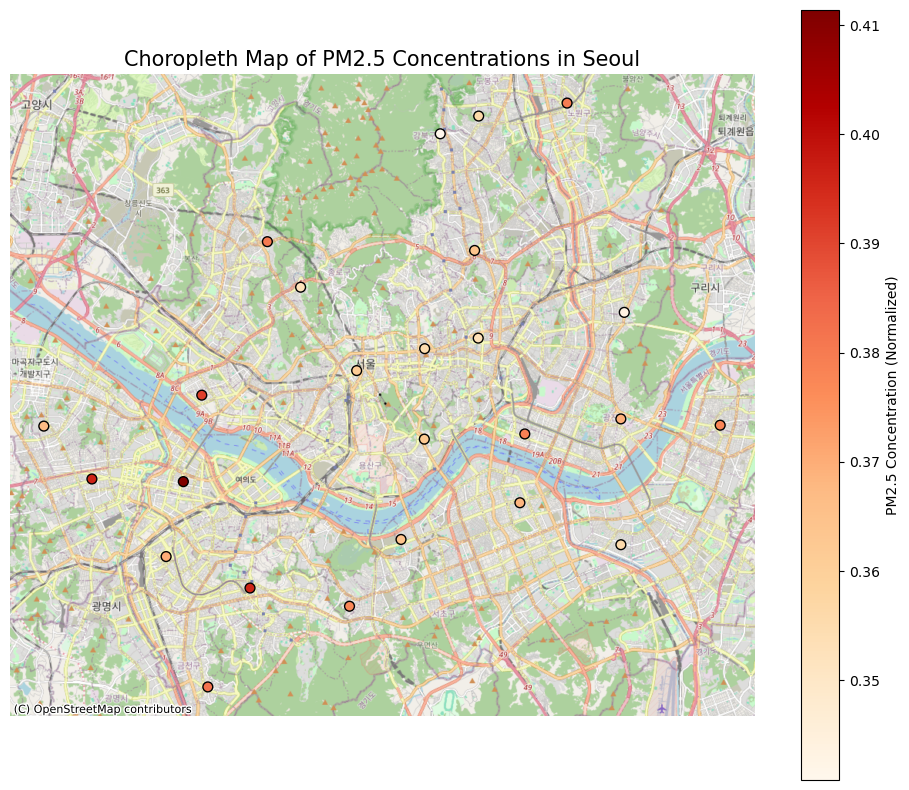

In [152]:
# Plot PM2.5 concentrations with basemap
plot_choropleth_with_basemap(gdf, 'PM2.5', 'Choropleth Map of PM2.5 Concentrations in Seoul')

In [153]:
# Extract spatial features (coordinates) and pollutant levels
coordinates = np.array([[geom.x, geom.y] for geom in gdf.geometry])  # Convert geometry to array
pollutant_levels = gdf[['PM2.5']].values  # Use PM2.5 for clustering

In [154]:
# Combine coordinates and pollutant levels
features = np.hstack([coordinates, pollutant_levels])

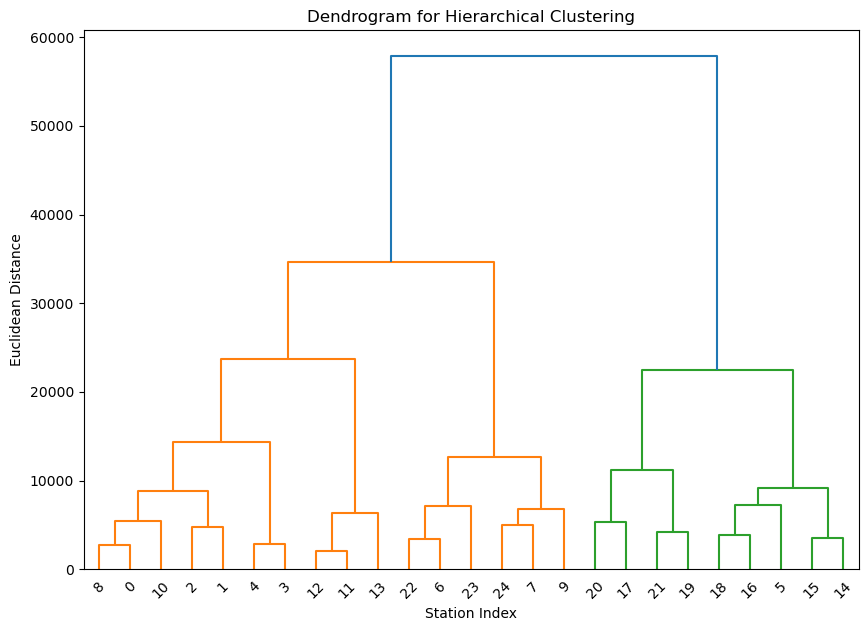

In [155]:
# Perform hierarchical clustering using linkage
linked = linkage(features, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Station Index')
plt.ylabel('Euclidean Distance')
plt.show()

In [156]:
# Define clusters based on a distance threshold
distance_threshold = 20000  # Adjust based on dendrogram
gdf['Cluster'] = fcluster(linked, t=distance_threshold, criterion='distance')

In [157]:
# Plot the clustered data
def plot_clusters(gdf, column, title):
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    gdf.plot(column=column, cmap='Set1', legend=True, ax=ax, markersize=50, edgecolor="black")
    ax.set_title(title, fontsize=15)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()
    plt.show()


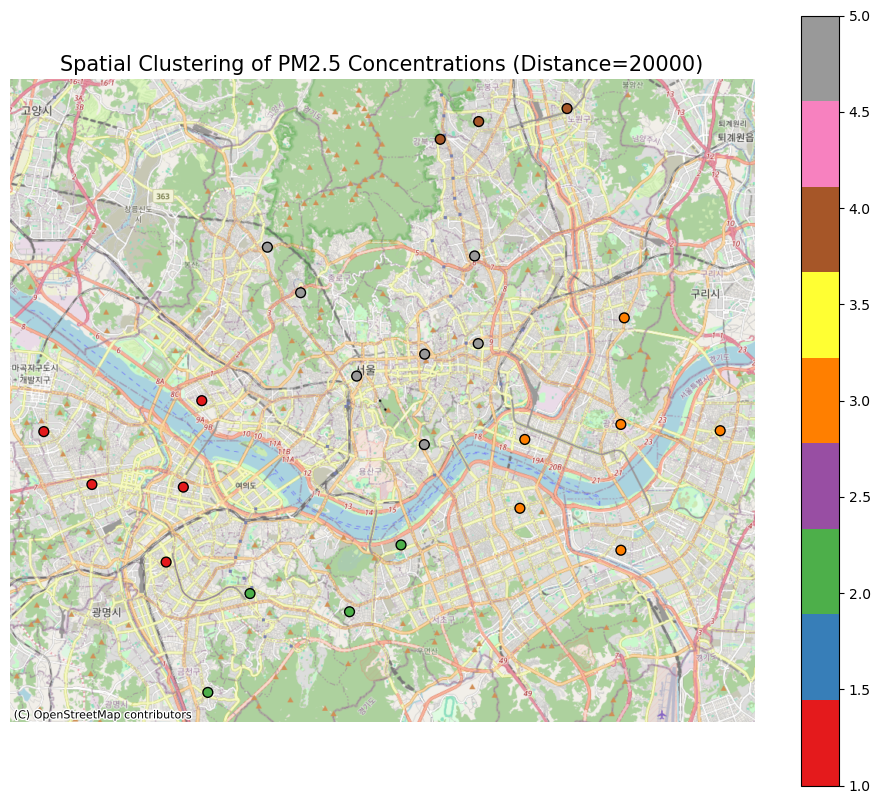

In [158]:
# Plot the clusters
plot_clusters(gdf, 'Cluster', f'Spatial Clustering of PM2.5 Concentrations (Distance={distance_threshold})')

In [159]:
# Ensure GeoDataFrame is in a projected coordinate system
if gdf.crs.is_geographic:
    gdf = gdf.to_crs(epsg=3857)


In [160]:
# Create spatial weights matrix using DistanceBand (e.g., 50km threshold)
distance_threshold = 50000  # 50 km
weights = DistanceBand.from_dataframe(gdf, threshold=distance_threshold, silence_warnings=True)


In [161]:
# Calculate Moran's I for PM2.5
pollutant = 'PM2.5'
moran = Moran(gdf[pollutant].values, weights)


In [162]:
# Print Moran's I results
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_sim}")


Moran's I: -0.04166666666666668
P-value: 0.423


In [163]:
local_moran = Moran_Local(gdf[pollutant].values, weights)


In [164]:
# Add Local Moran's I results to the GeoDataFrame
gdf['Local Moran'] = local_moran.Is
gdf['p-value'] = local_moran.p_sim
gdf['Hotspot'] = gdf['p-value'] < 0.05  # Mark significant hotspots


In [165]:
# Plot the hotspots on the map
def plot_hotspots(gdf, title):
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    gdf.plot(column='Hotspot', cmap='coolwarm', legend=True, ax=ax, markersize=50, edgecolor="black")
    ax.set_title(title, fontsize=15)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()
    plt.show()

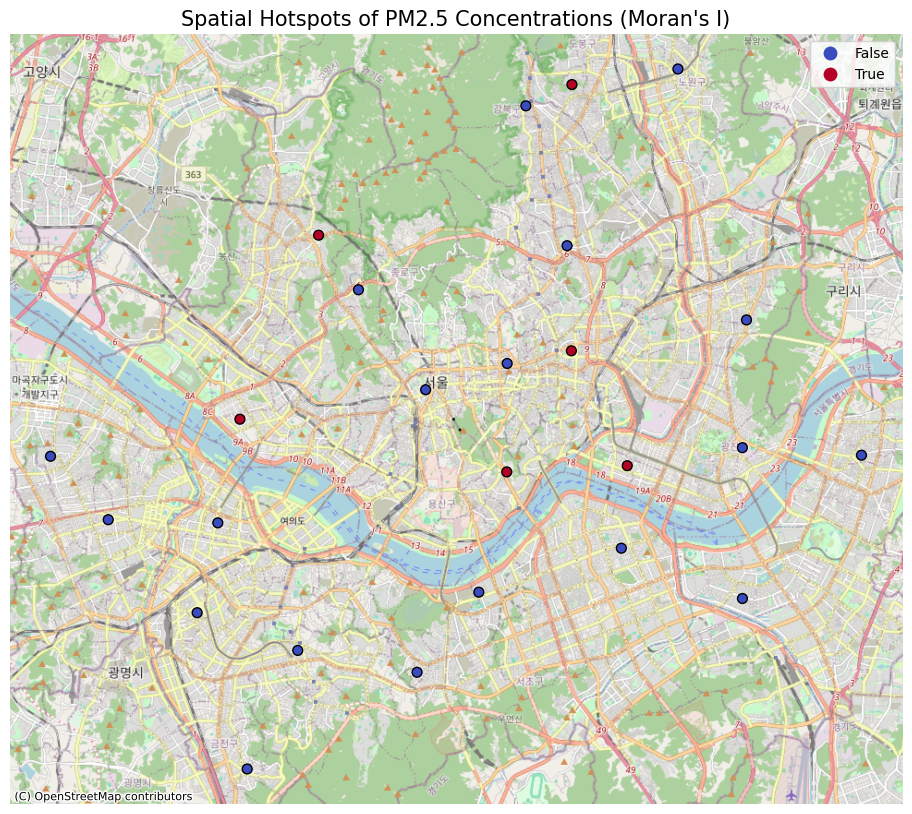

In [166]:
# Plot the significant hotspots
plot_hotspots(gdf, 'Spatial Hotspots of PM2.5 Concentrations (Moran\'s I)')

In [169]:
monthly_data.head()

Month  Station code   Latitude   Longitude       SO2       NO2        O3  \
0  2017-01           101  37.572016  127.005008  0.510753  0.521108  0.202321   
1  2017-01           102  37.564263  126.974676  0.526798  0.536584  0.193312   
2  2017-01           103  37.540033  127.004850  0.567456  0.448281  0.165650   
3  2017-01           104  37.609823  126.934848  0.536122  0.365383  0.193076   
4  2017-01           105  37.593742  126.949679  0.707913  0.395313  0.243443   

         CO      PM10     PM2.5  
0  0.584917  0.477239  0.496364  
1  0.532007  0.486824  0.508825  
2  0.551099  0.434153  0.481535  
3  0.663535  0.484333  0.450787  
4  0.608887  0.514751  0.446677

In [171]:
# Aggregate pollutant data by season for heatmap visualization
monthly_heatmap_data = monthly_data.groupby('Month')[['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']].mean()

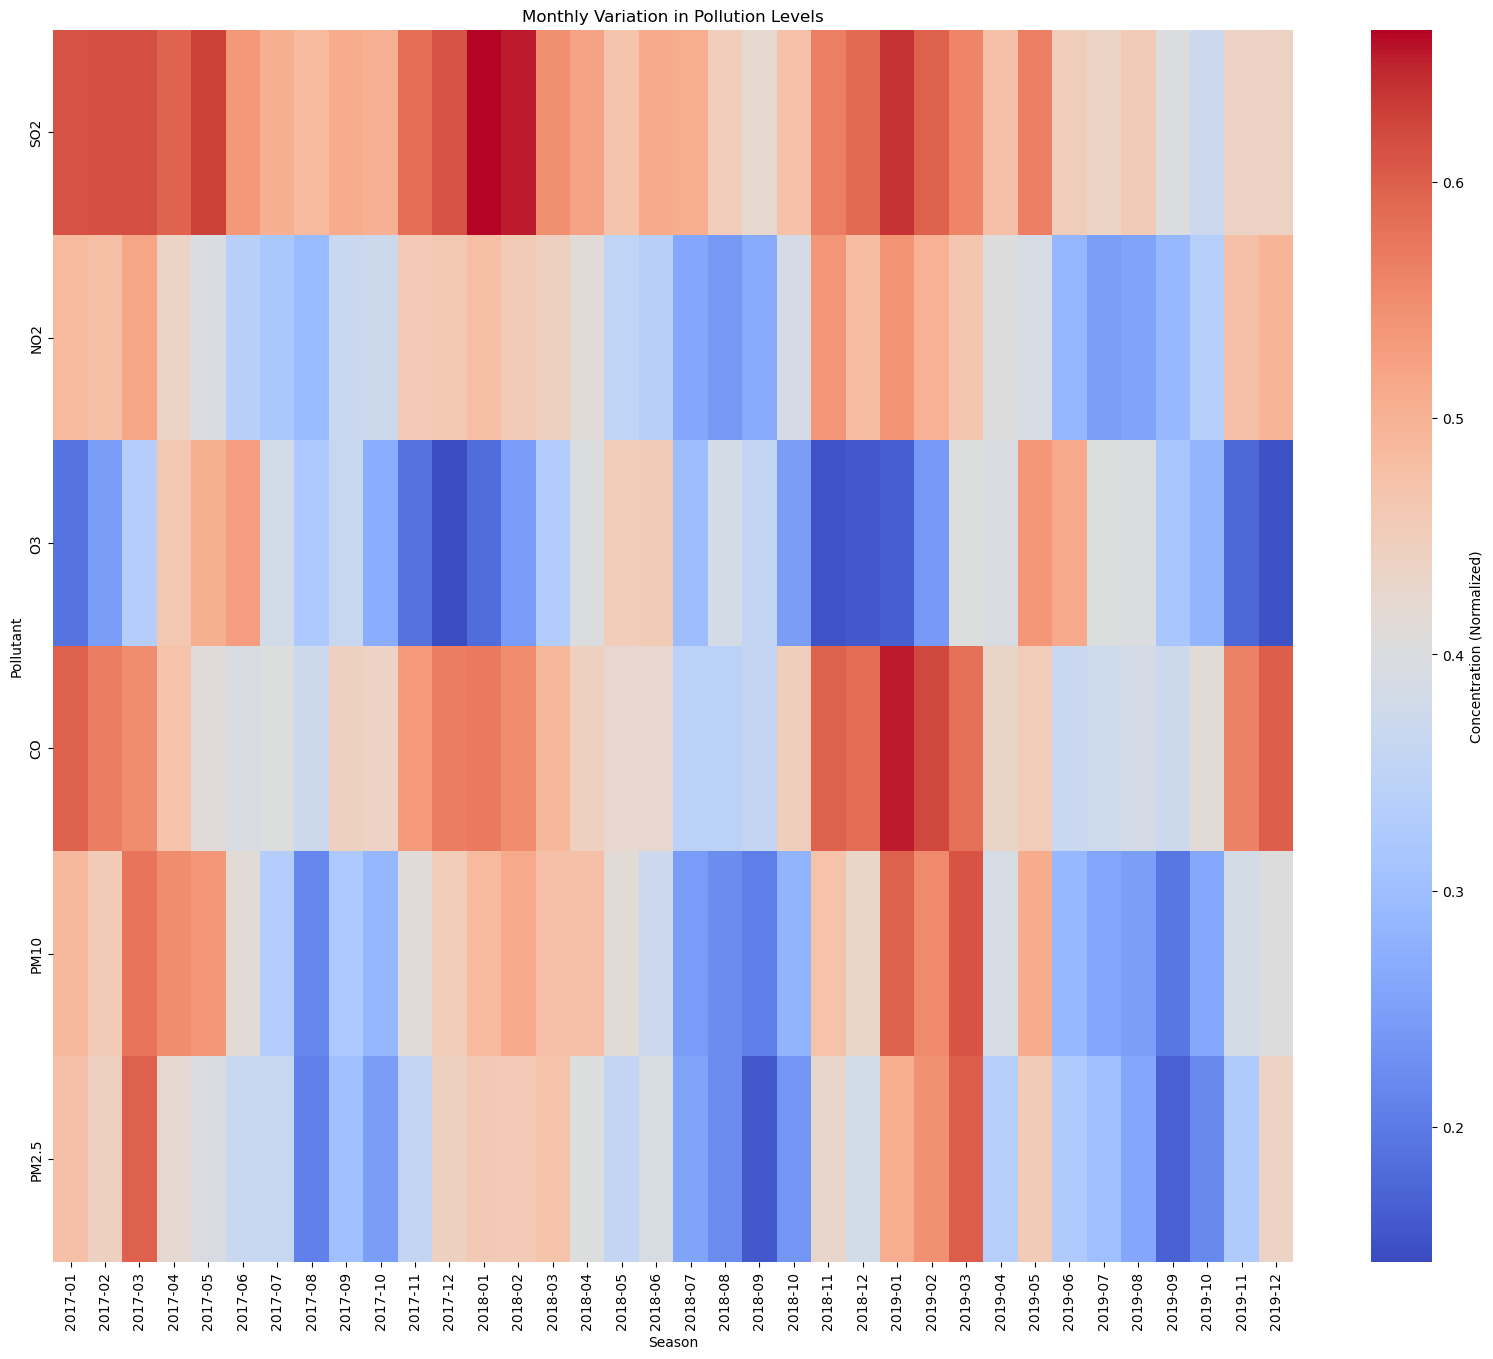

In [174]:
# Generate Seasonal Heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(monthly_heatmap_data.T,  cmap='coolwarm', cbar_kws={'label': 'Concentration (Normalized)'})
plt.title('Monthly Variation in Pollution Levels')
plt.ylabel('Pollutant')
plt.xlabel('Season')
plt.show()

In [175]:
# Aggregate pollutant data by station and season for line chart analysis
# Filter for PM2.5 concentrations for temporal trends
pm25_trends = monthly_data.groupby(['Month', 'Station code'])[['PM2.5']].mean().reset_index()

In [176]:
# Filter data for hotspots using identified station codes (from `gdf`)
hotspot_stations = gdf[gdf['Hotspot']]['Station code'].unique()
hotspot_pm25_trends = pm25_trends[pm25_trends['Station code'].isin(hotspot_stations)]


In [179]:
station_data.head()

Month  Station code     PM2.5
2    2017-01           103  0.481535
27   2017-02           103  0.430230
52   2017-03           103  0.553631
77   2017-04           103  0.416041
102  2017-05           103  0.391482

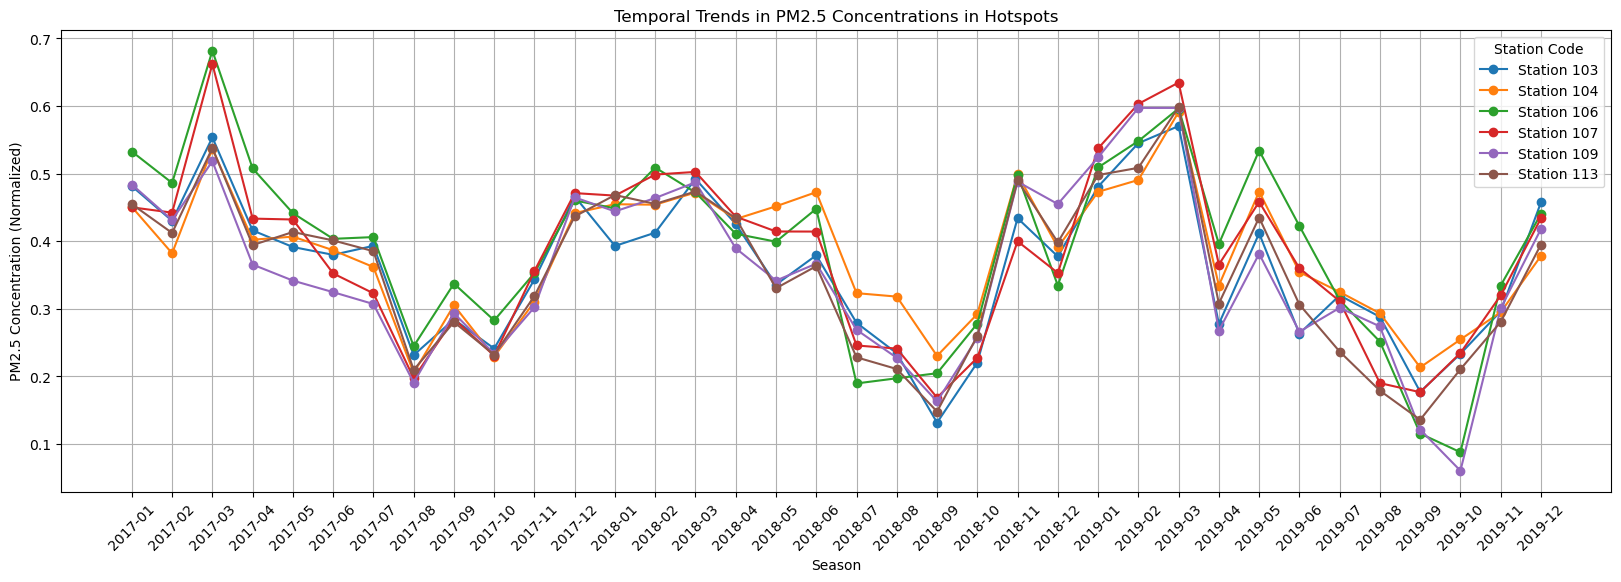

In [191]:
# Plot Line Chart for Temporal Trends in Hotspots
plt.figure(figsize=(20, 6))
for station in hotspot_stations:
    station_data = hotspot_pm25_trends[hotspot_pm25_trends['Station code'] == station]
    plt.plot(station_data['Month'].astype(str), station_data['PM2.5'], marker='o', label=f'Station {station}')

plt.title('Temporal Trends in PM2.5 Concentrations in Hotspots')
plt.xlabel('Season')
plt.ylabel('PM2.5 Concentration (Normalized)')
plt.xticks(rotation=45)
plt.legend(title='Station Code')
plt.grid(True)
plt.show()

In [192]:
# Hotspot persistance

In [199]:
# Define a PM2.5 hotspot threshold (e.g., 90th percentile)
hotspot_threshold = monthly_data['PM2.5'].quantile(0.9)

In [201]:
# Add a column to indicate whether a station is a hotspot for each month
monthly_data['Hotspot'] = monthly_data['PM2.5'] > hotspot_threshold

# Calculate the frequency of exceedances by station and month
exceedances = monthly_data.groupby(['Station code', 'Month'])['Hotspot'].sum().reset_index(name='Exceedances')

# Add total observations per station per month for normalization
total_observations = monthly_data.groupby(['Station code', 'Month'])['PM2.5'].count().reset_index(name='Total Observations')
exceedances = exceedances.merge(total_observations, on=['Station code', 'Month'])

# Calculate the proportion of exceedances (frequency)
exceedances['Persistence'] = exceedances['Exceedances'] / exceedances['Total Observations']

In [202]:
# Calculate average persistence for each station across all months
hotspot_persistence = exceedances.groupby('Station code')['Persistence'].mean().reset_index()

# Add persistence scores to the GeoDataFrame
gdf = gdf.merge(hotspot_persistence, on='Station code', how='left')

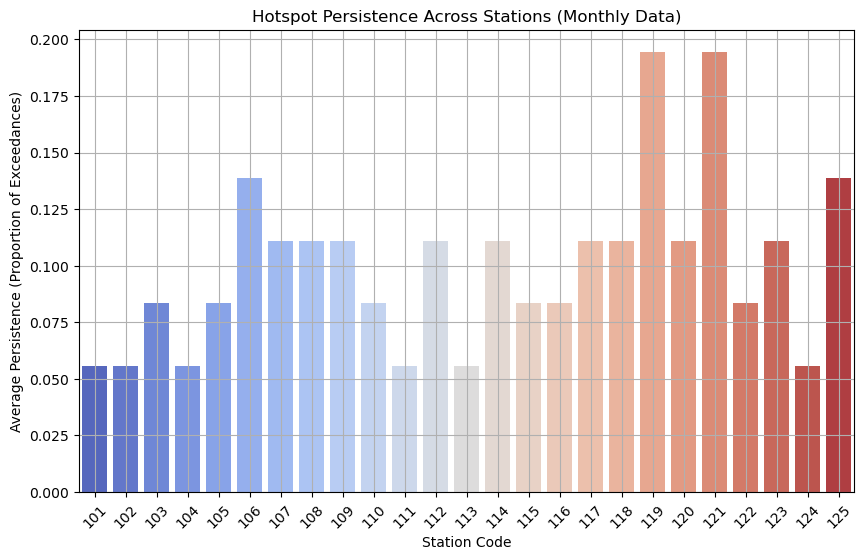

In [204]:
# Visualize persistence scores
plt.figure(figsize=(10, 6))
sns.barplot(x=gdf['Station code'], y=gdf['Persistence'], palette='coolwarm')
plt.title('Hotspot Persistence Across Stations (Monthly Data)')
plt.xlabel('Station Code')
plt.ylabel('Average Persistence (Proportion of Exceedances)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [210]:
# Identify persistent hotspot stations
persistent_stations = gdf[gdf['Persistence'] > 0.125]['Station code'].unique()

# Filter data for persistent stations
monthly_persistent_data = monthly_data[monthly_data['Station code'].isin(persistent_stations)]

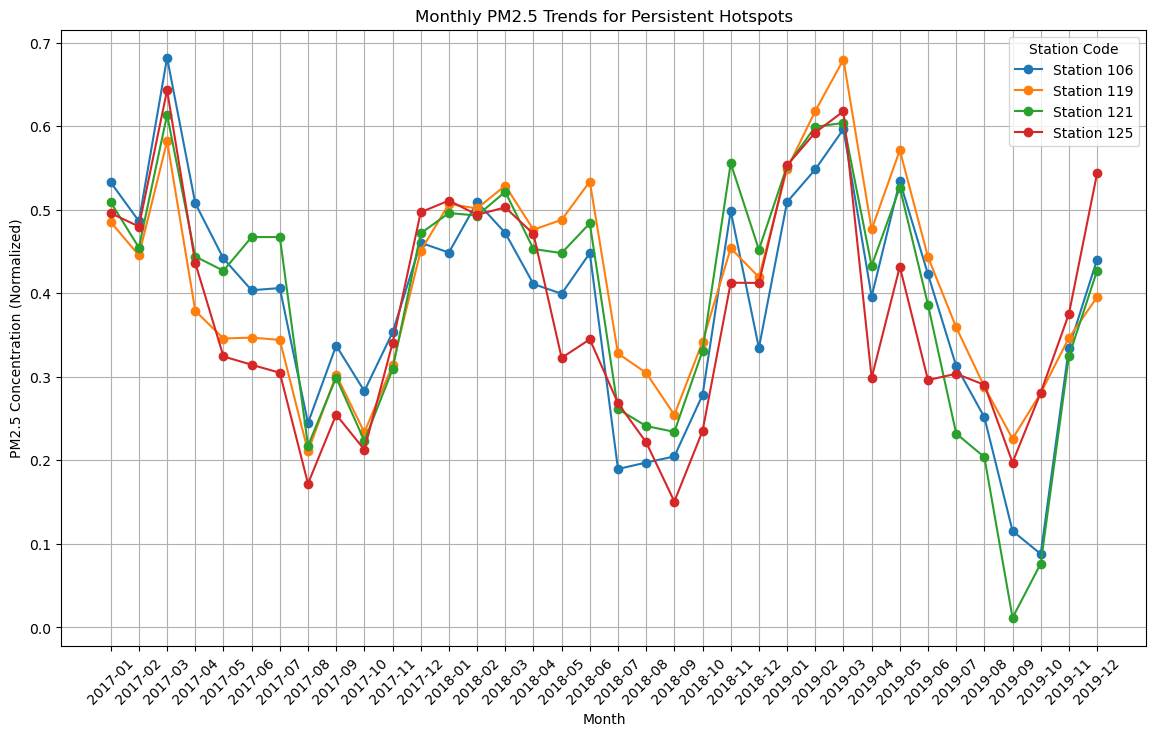

In [211]:
# Visualize PM2.5 trends for persistent hotspots
plt.figure(figsize=(14, 8))
for station in persistent_stations:
    station_data = monthly_persistent_data[monthly_persistent_data['Station code'] == station]
    plt.plot(station_data['Month'].astype(str), station_data['PM2.5'], marker='o', label=f'Station {station}')

plt.title('Monthly PM2.5 Trends for Persistent Hotspots')
plt.xlabel('Month')
plt.ylabel('PM2.5 Concentration (Normalized)')
plt.xticks(rotation=45)
plt.legend(title='Station Code')
plt.grid(True)
plt.show()

In [182]:
# Analyze hotspot persistence across seasons
hotspot_persistence = monthly_data[monthly_data['Station code'].isin(hotspot_stations)].groupby(['Month', 'Station code'])[['PM2.5']].mean().reset_index()

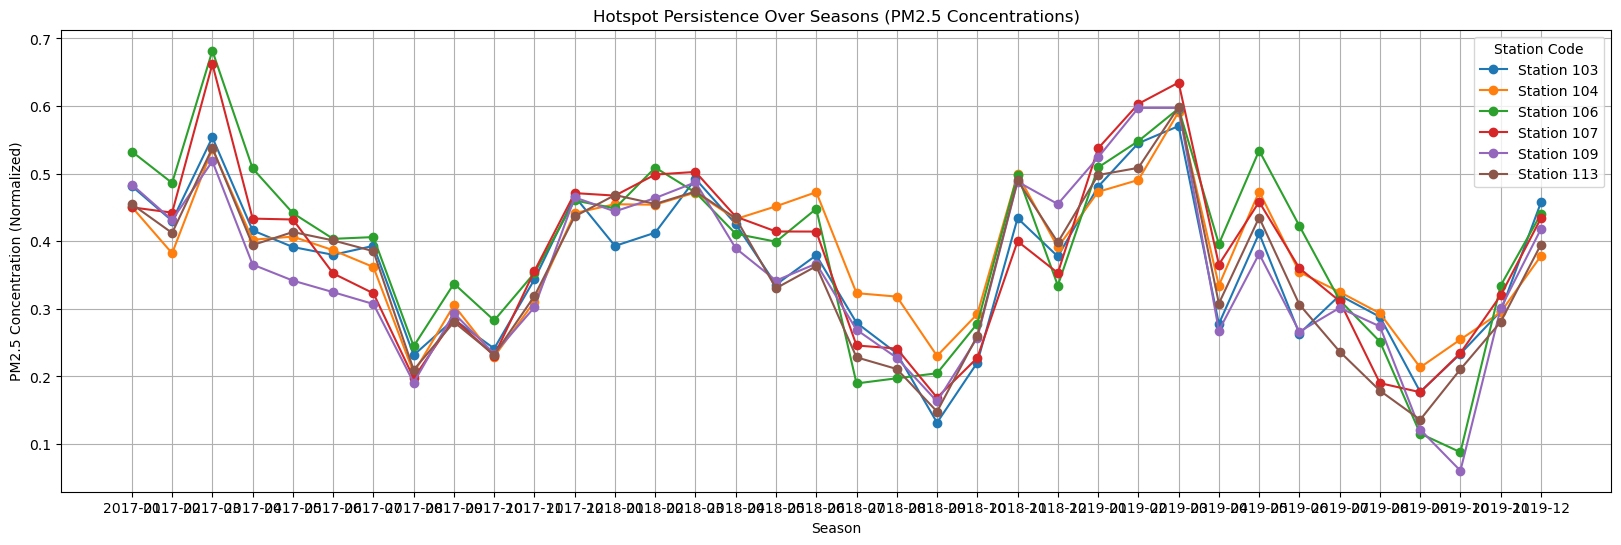

In [184]:
# Visualize hotspot persistence over seasons
plt.figure(figsize=(20, 6))
for station in hotspot_stations:
    station_data = hotspot_persistence[hotspot_persistence['Station code'] == station]
    plt.plot(station_data['Month'].astype(str), station_data['PM2.5'], marker='o', label=f'Station {station}')

plt.title('Hotspot Persistence Over Seasons (PM2.5 Concentrations)')
plt.xlabel('Season')
plt.ylabel('PM2.5 Concentration (Normalized)')
plt.legend(title='Station Code')
plt.grid(True)

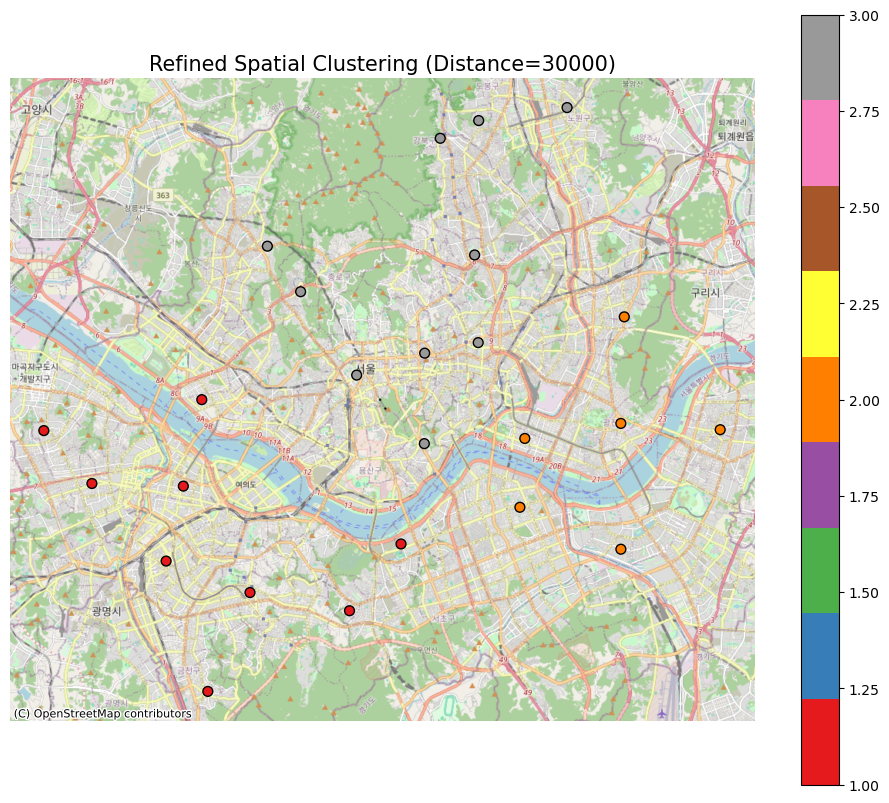

In [125]:
# Refine distance threshold based on persistence insights
new_distance_threshold = 30000  # Adjusted threshold (e.g., increase for more granular clusters)
gdf['Cluster_Refined'] = fcluster(linked, t=new_distance_threshold, criterion='distance')

# Visualize refined clusters
plot_clusters(gdf, 'Cluster_Refined', f'Refined Spatial Clustering (Distance={new_distance_threshold})')

In [185]:
# Aggregate data monthly for hotspot stations
daily_hotspot_data = daily_data[daily_data['Station code'].isin(hotspot_stations)]


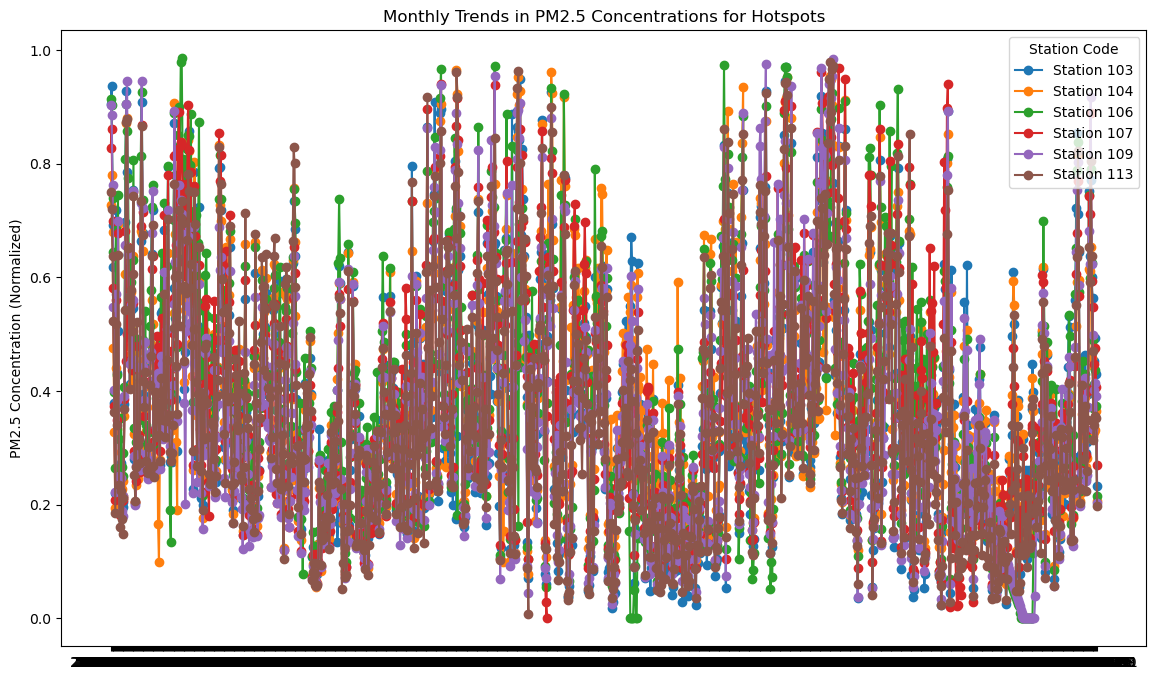

In [190]:
# Visualize PM2.5 trends for hotspots at a monthly granularity
plt.figure(figsize=(14, 8))
for station in hotspot_stations:
    station_data = daily_hotspot_data[daily_hotspot_data['Station code'] == station]
    plt.plot(station_data['Date'].astype(str), station_data['PM2.5'], marker='o', label=f'Station {station}')

plt.title('Monthly Trends in PM2.5 Concentrations for Hotspots')
plt.ylabel('PM2.5 Concentration (Normalized)')
plt.legend(title='Station Code')
plt.show()